# Início

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
from scipy import signal
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

In [3]:
# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

In [4]:
# Udata está organizado como [usuario][posicao][atividade][tempo][dims]
Dtr = np.array(Udata[5][0])[:, :11000, :]
Xtr = Dtr.reshape(-1).reshape(770, 600)

In [5]:
Xtr.shape

(770, 600)

In [6]:
Dtr.shape

(7, 11000, 6)

In [48]:
px.line(Dtr[2])

In [4]:
def plotCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    # px.scatter(x=ex,y=ey)
    plt.plot(ex,ey)
    return ex, ey

In [22]:
X = np.array(Udata[5][0])[0, 1500:4500, :]
t0 = time.time()
N = X.shape[0]
L = N*(N-1)//2
rx = np.zeros(L)
cont = 0
for i in range(N-1):
    for j in range(i+1,N):
        rx[cont] = max(abs(X[i,:]-X[j,:]))*2
        cont += 1

t1 = time.time()
print(t1-t0)

9.4838547706604


In [23]:
t0 = time.time()
rx = np.sort(rx)
# rx = rx.sort()
t1 = time.time()
print(t1-t0)

0.2857844829559326


(array([-2.07694535, -1.95135311, -1.79116185, ...,  5.38693034,
         5.47316415,  5.50458398]),
 array([-1.86259585e+01, -1.76259585e+01, -1.70409960e+01, ...,
        -7.13236241e-06, -3.56617680e-06,  0.00000000e+00]))

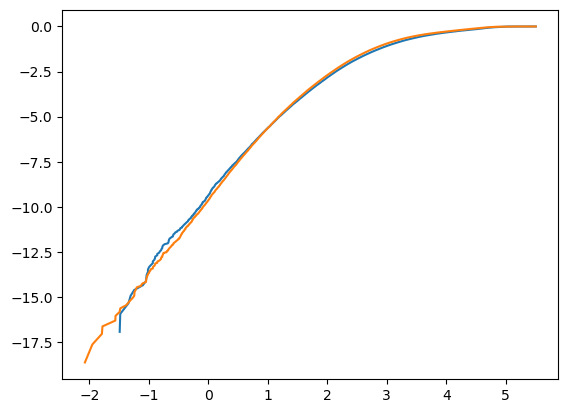

In [27]:
X = np.array(Udata[5][0])[0, 1500:2000, :]
ex, ey = plotCR(X)
X = np.array(Udata[5][0])[0, 1500:2400, :]
plotCR(X)

# Exploração de métodos de análise do plotCR

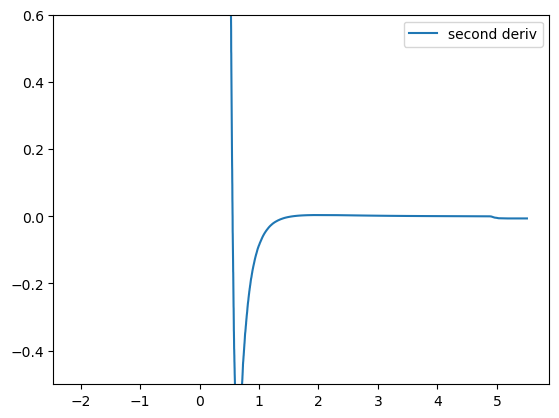

In [68]:
# calculate second order deriv.
y_conv = np.convolve(ey, y1, mode="same")

# plot data
plt.plot(ex,y_conv, label = "second deriv")
# plt.plot(ex, ey,"o", label = "noisy data")
# plt.hlines([0],-10, 20)
# plt.axvspan(0,4, color="y", alpha=0.2)
# plt.axvspan(6,14, color="y", alpha=0.2)
# plt.axhspan(-1,1, color="b", alpha=0.2)
# plt.vlines([0, 4, 6],-10, 10)
# plt.xlim(-2.5,12)
plt.ylim(-0.5,0.6)
plt.legend(loc=0)
plt.show()

In [52]:
# create theoretical data
x_a = np.linspace(-8,0, 60)
y_a = np.sin(x_a)
x_b = np.linspace(0,4,30)[1:]
y_b = x_b[:]
x_c = np.linspace(4,6,15)[1:]
y_c = np.sin((x_c - 4)/4*np.pi)/np.pi*4. + 4
x_d = np.linspace(6,14,120)[1:]
y_d = np.zeros(len(x_d)) + 4 + (4/np.pi)

x = np.concatenate((x_a, x_b, x_c, x_d))
y = np.concatenate((y_a, y_b, y_c, y_d))


# make noisy data from theoretical data
y_n = y + np.random.normal(0, 0.27, len(x))

# create convolution kernel for calculating
# the smoothed second order derivative
smooth_width = 59
x1 = np.linspace(-3,3,smooth_width)
norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])

In [66]:
smooth_width = 10000
x1 = np.linspace(-3,3,smooth_width)
norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])
px.line(x=x1,y=y1)

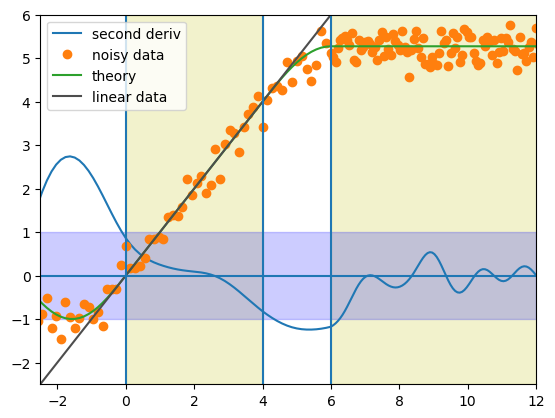

In [53]:
# calculate second order deriv.
y_conv = np.convolve(y_n, y1, mode="same")

# plot data
plt.plot(x,y_conv, label = "second deriv")
plt.plot(x, y_n,"o", label = "noisy data")
plt.plot(x, y, label="theory")
plt.plot(x, x, "0.3", label = "linear data")
plt.hlines([0],-10, 20)
plt.axvspan(0,4, color="y", alpha=0.2)
plt.axvspan(6,14, color="y", alpha=0.2)
plt.axhspan(-1,1, color="b", alpha=0.2)
plt.vlines([0, 4, 6],-10, 10)
plt.xlim(-2.5,12)
plt.ylim(-2.5,6)
plt.legend(loc=0)
plt.show()

In [ ]:
from scipy import optimize

In [9]:
import piecewise_regression

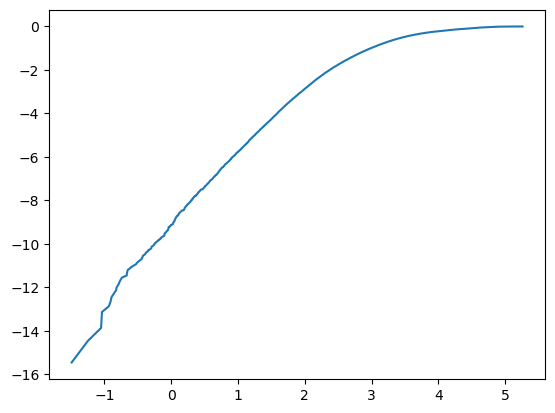

In [13]:
X = np.array(Udata[5][0])[0, 1700:2000, :]
ex, ey = plotCR(X)

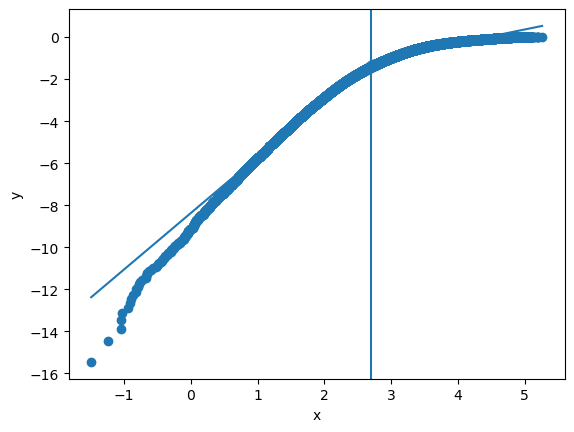

In [15]:
pw_fit = piecewise_regression.Fit(ex, ey, n_breakpoints=1)
pw_fit.plot()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [69]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p = piecewise_linear
p

<function __main__.piecewise_linear(x, x0, y0, k1, k2)>

In [70]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

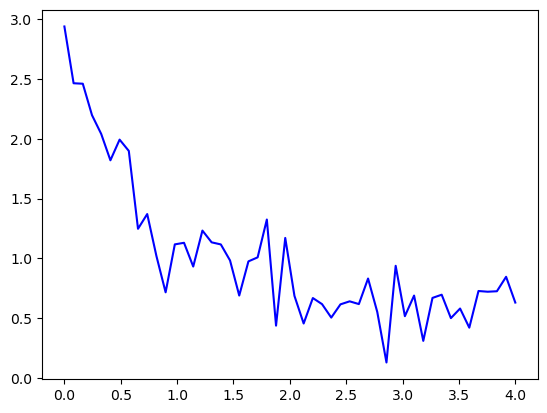

In [71]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

In [72]:
from scipy.optimize import curve_fit

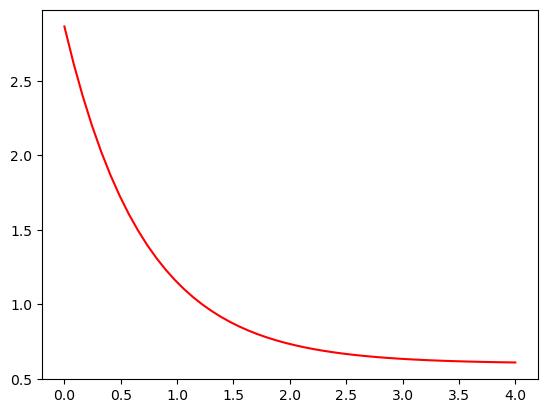

In [73]:
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

# Método de Luizinho

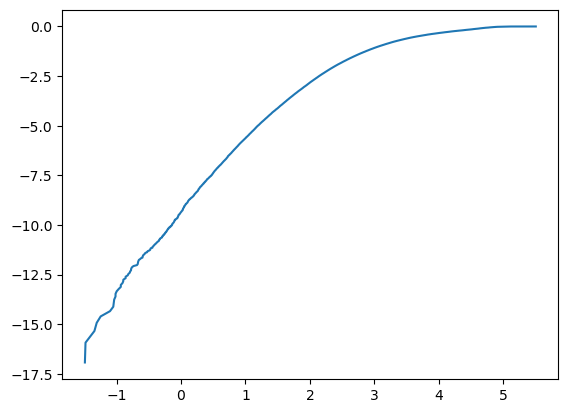

In [10]:
X = np.array(Udata[5][0])[0, 1500:2000, :]
ex, ey = plotCR(X)

In [20]:
regre = LinearRegression().fit(ex.reshape(-1, 1), ey)

In [22]:
regre.score(ex.reshape(-1, 1), ey)

0.8402409602044287

In [26]:
b = regre.intercept_
a = regre.coef_
a, b

(array([1.32226288]), -5.516672990627428)

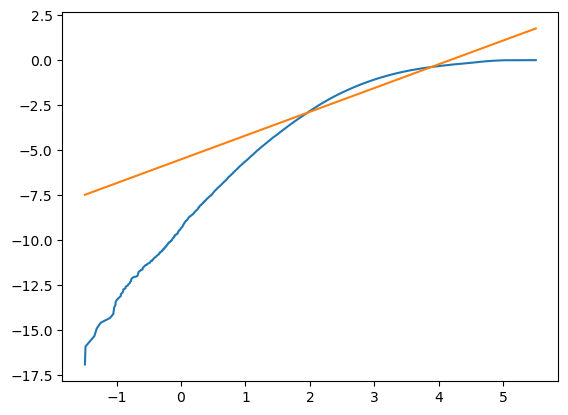

In [25]:
plt.plot(ex,ey)
plt.plot([min(ex), max(ex)], [min(ex), max(ex)]*a+b)

In [33]:
limi = min(ex)+(max(ex)-min(ex))/3
lims = max(ex)-(max(ex)-min(ex))/3
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
limi, lims

(0.8402475388997956, 3.1724157569580167)

In [34]:
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
b = regre.intercept_
a = regre.coef_
a, b

(array([2.06330916]), -7.103007163010476)

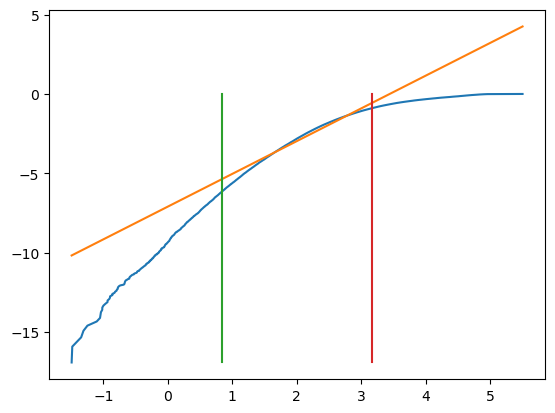

In [37]:
plt.plot(ex,ey)
plt.plot([min(ex), max(ex)], [min(ex), max(ex)]*a+b)
plt.plot([limi, limi],[min(ey),max(ey)])
plt.plot([lims, lims],[min(ey),max(ey)])

0.9966300340723826 0 1746
0.9746735546951372 1746 67210
0.9658636695117153 67210 124749


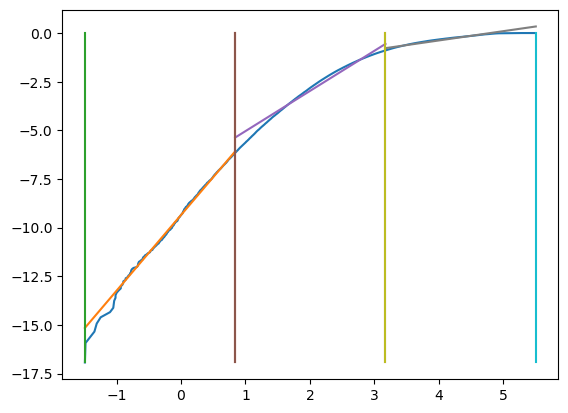

In [57]:
k = 3
faixa = (max(ex)-min(ex))/k
plt.plot(ex,ey)
for i in range(k):
    limi = min(ex)+faixa*i
    lims = min(ex)+faixa*(i+1)
    ni = np.argmin(abs(ex-limi))
    ns = np.argmin(abs(ex-lims))
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    b = regre.intercept_
    a = regre.coef_
    print(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]), ni, ns)
    plt.plot([ex[ni], ex[ns]], [ex[ni], ex[ns]]*a+b)
    plt.plot([limi, limi],[min(ey),max(ey)])
    plt.plot([lims, lims],[min(ey),max(ey)])

In [66]:
5/17

0.29411764705882354

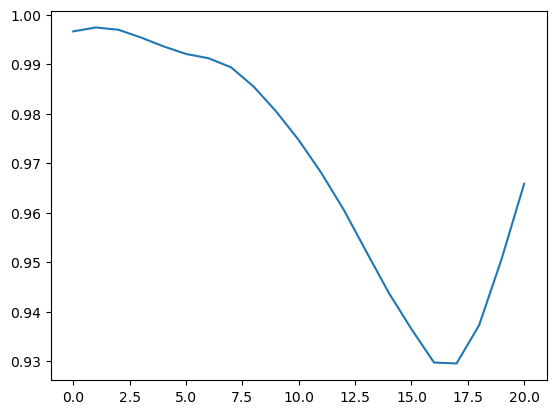

In [72]:
k = 30
janela = 10
faixa = (max(ex)-min(ex))/k
score = []
for i in range(k-janela+1):
    limi = min(ex)+faixa*i
    lims = min(ex)+faixa*(i+janela)
    ni = np.argmin(abs(ex-limi))
    ns = np.argmin(abs(ex-lims))
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    b = regre.intercept_
    a = regre.coef_
    score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    # print(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]), ni, ns)
    # plt.figure(i+1)
    # plt.plot(ex,ey)
    # plt.plot([ex[ni], ex[ns]], [ex[ni], ex[ns]]*a+b)
    # plt.plot([limi, limi],[min(ey),max(ey)])
    # plt.plot([lims, lims],[min(ey),max(ey)])
plt.figure(i+2)
plt.plot(score)

# Medindo DI entre domínios...

## Funções

In [5]:
def getDI(ex,ey,printFLag=False):
    k = 30
    janela = 10
    faixa = (max(ex)-min(ex))/k
    score = []
    dim = []
    b = []
    for i in range(k-janela+1):
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
        dim.append(regre.coef_[0])
        b.append(regre.intercept_)
        score.append(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]))
    i = np.argmax(score)
    if printFLag:
        limi = min(ex)+faixa*i
        lims = min(ex)+faixa*(i+janela)
        ni = np.argmin(abs(ex-limi))
        ns = np.argmin(abs(ex-lims))
        plt.plot(ex,ey)
        plt.plot([ex[ni], ex[ns]], np.array([ex[ni], ex[ns]])*dim[i]+b[i])
    return dim[i]

In [6]:
def getCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    rx = rx[rx>0]
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    return ex, ey

## Análise para um usuário

Usuário: proband3
Posição: chest
Atividade : climbingdown


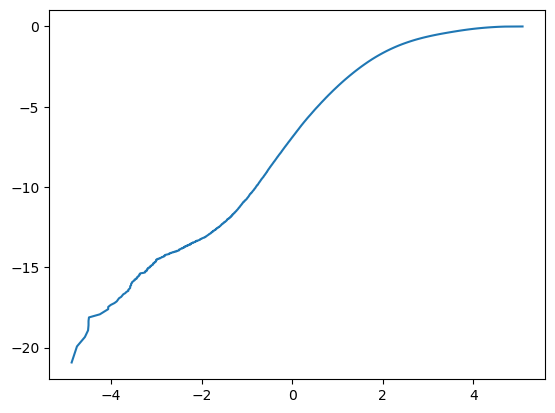

In [30]:
# Udata está organizado como [usuario][posicao][atividade][tempo][dims]
nu = 0
nd = 0
na = 0
Na = 21000
Ne = 2000
X = np.array(Udata[nu][nd])[na, :, :]
inds = np.random.permutation(Na)[:Ne]
print('Usuário: '+users[nu]+'\nPosição: '+posis[nd]+'\nAtividade : '+actis[na])
ex, ey = plotCR(X[inds])

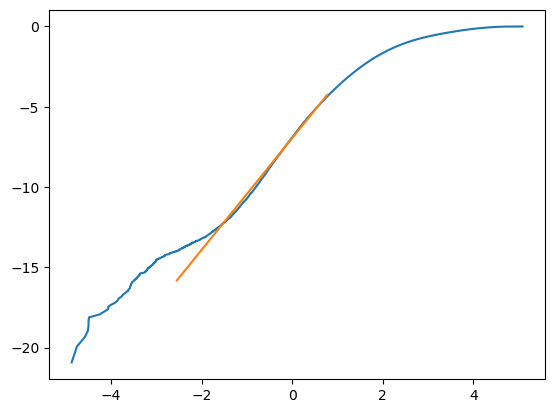

In [43]:
d = getDI(ex,ey,printFLag=True)

Usuário: proband3
Posição: chest
Atividade : lying


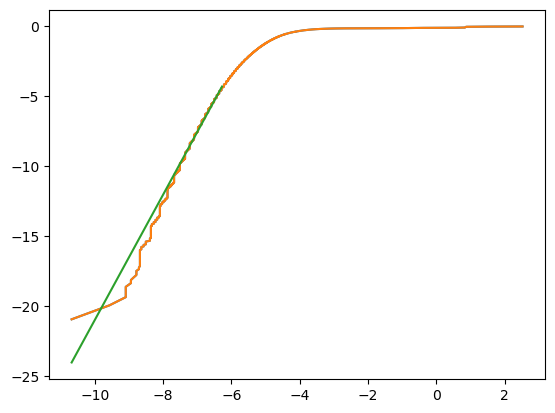

In [84]:
nu = 0
nd = 0
na = 2
Na = 21000
Ne = 2000
print('Usuário: '+users[nu]+'\nPosição: '+posis[nd]+'\nAtividade : '+actis[na])
X1 = np.array(Udata[nu][nd])[na, :, :]
X1[:,:3] = X1[:,:3]/10
X2 = np.array(Udata[nu][nd+1])[na, :, :]
X2[:,:3] = X2[:,:3]/10
X = np.vstack((X1, X2))
inds = np.random.permutation(Na)[:Ne]
ex, ey = plotCR(X[inds])
d = getDI(ex,ey,printFLag=True)

In [85]:
d

4.478317515350984

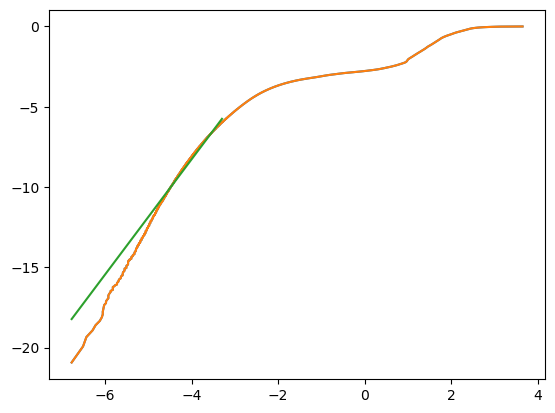

In [82]:
nu = 0
nd = 0
na = 3
Na = 21000
Ne = 2000
X1 = np.array(Udata[nu][nd])[na, :, :]
X1[:,:3] = X1[:,:3]/10
X2 = np.array(Udata[nu][nd+1])[na, :, :]
X2[:,:3] = X2[:,:3]/10
X = np.vstack((X1, X2))
inds = np.random.permutation(Na)[:Ne]
ex, ey = plotCR(X[inds])
d = getDI(ex,ey,printFLag=True)

In [83]:
d

3.5932661480231416

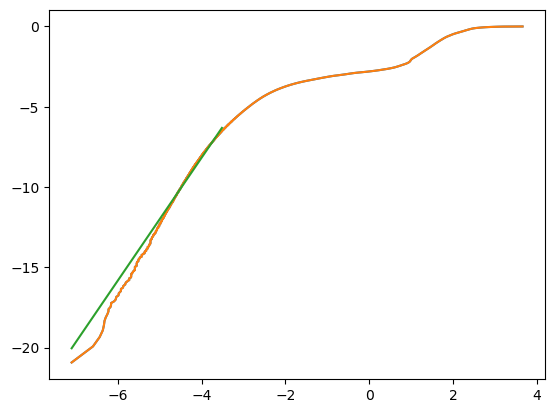

In [80]:
nu = 0
nd = 0
na = 3
Na = 21000
Ne = 2000
X = np.array(Udata[nu][nd])[na, :, :]
X[:,:3] = X[:,:3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = plotCR(X[inds])
d = getDI(ex,ey,printFLag=True)

In [81]:
d

3.831780917588502

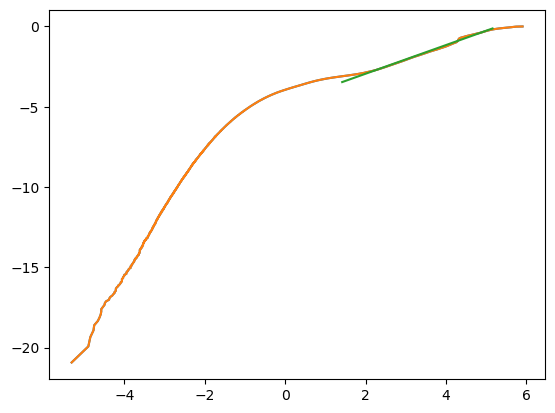

In [77]:
nu = 0
nd = 0
na = 3
Na = 21000
Ne = 2000
X = np.array(Udata[nu][nd])[na, :, :]
# X[:,:3] = X[:,:3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = plotCR(X[inds])
d = getDI(ex,ey,printFLag=True)

In [78]:

print('Usuário: '+users[nu]+'\nPosição: '+posis[nd]+'\nAtividade : '+actis[na])

Usuário: proband3
Posição: chest
Atividade : running


In [79]:
d

0.8925922701158158

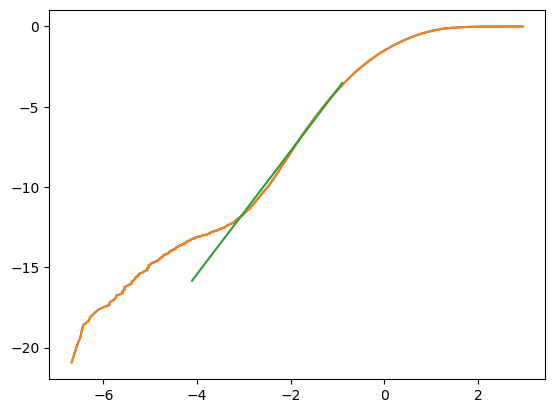

In [57]:
nu = 0
nd = 0
na = 0
Na = 21000
Ne = 2000
X = np.array(Udata[nu][nd])[na, :, :]
X[:,:3] = X[:,:3]/10
inds = np.random.permutation(Na)[:Ne]
ex, ey = plotCR(X[inds])
d = getDI(ex,ey,printFLag=False)

In [64]:
2**(-7)

0.0078125

In [69]:
# X[:,:3] = X[:,:3]/10
print('Usuário: '+users[nu]+'\nPosição: '+posis[nd]+'\nAtividade : '+actis[na])
px.line(X)

Usuário: proband3
Posição: chest
Atividade : lying


In [165]:
nu = 0
DIest = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :]
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[na,nd] = getDI(ex,ey)

In [166]:
fig = px.imshow(DIest, width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [167]:
nu = 1
DIest = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :]
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[na,nd] = getDI(ex,ey)

In [168]:
fig = px.imshow(DIest, width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [171]:
Ne = 2000
nu = 1
DIest = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :]
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[na,nd] = getDI(ex,ey)

In [174]:
fig = px.imshow(DIest, width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [169]:
nu = 2
DIest = np.zeros((7,7))
for nd in tqdm(range(len(posis))):
    for na in range(len(actis)):
        X = np.array(Udata[nu][nd])[na, :, :]
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[na,nd] = getDI(ex,ey)

In [170]:
fig = px.imshow(DIest, width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [120]:
pd.DataFrame(DIest.round(3),index=actis,columns=posis)

chest  forearm   head   shin  thigh  upperarm  waist
climbingdown  3.225    3.631  3.224  2.450  3.473     3.738  3.170
climbingup    3.529    4.121  3.698  3.432  3.391     3.588  3.447
lying         3.300    3.560  0.686  2.431  2.483     0.824  3.634
running       0.897    0.996  0.929  2.704  3.148     0.740  0.942
sitting       3.347    0.992  3.323  3.220  3.434     3.077  3.405
standing      3.995    3.841  3.177  0.581  3.813     3.455  4.094
walking       3.507    4.251  4.315  3.235  3.084     3.957  3.611

In [127]:
px.imshow(DIest, width=800, title=users[nu],
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)

In [163]:
X[inds].shape

(1000, 6)

In [164]:
Na = 21000
Ne = 500
nu = 1
DIest = np.zeros((7,7))
UDI = []
for nu in tqdm(range(10)):
    for nd in range(len(posis)):
        for na in range(len(actis)):
            X = np.array(Udata[nu][nd])[na, :, :]
            inds = np.random.permutation(Na)[:Ne]
            ex, ey = getCR(X[inds])
            DIest[na,nd] = getDI(ex,ey)
    UDI.append(DIest)

 14%|█▍        | 1/7 [00:04<00:25,  0.24it/s]

KeyboardInterrupt: 

In [160]:
nu = 0
fig = px.imshow(UDI[nu], width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

In [161]:
nu = 1
fig = px.imshow(UDI[nu], width=800, title=users[nu], zmax=5, zmin=0,
                labels=dict(y='Atividade', x='Posição', color='Dimensão estimada'),
                y=actis,
                x=posis)
fig.show()

## DI acc e gyr

In [11]:
Na = 21000
Ne = 2000
DIest = np.zeros((10,7))
for nd in tqdm(range(len(posis))):
    for nu in range(10):
        X = np.array(Udata[nu][nd])[:, :, :3].reshape(7*21000,3)
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[nu,nd] = getDI(ex,ey)
DIest.round(1)

100%|██████████| 7/7 [27:00<00:00, 231.45s/it]


array([[2.5, 2.6, 2.7, 2.3, 2.5, 2.7, 2.7],
       [2.9, 2.8, 2.9, 2.6, 2.8, 2.9, 2.9],
       [2.4, 2.6, 2.7, 2.4, 2.5, 2.7, 2.8],
       [2.7, 2.8, 3. , 2.7, 2.6, 2.8, 2.7],
       [2.8, 2.8, 2.9, 2.4, 2.5, 2.9, 2.9],
       [2.7, 2.7, 2.8, 2.5, 2.5, 2.7, 2.8],
       [2.8, 2.6, 2.8, 2.4, 2.6, 2.6, 2.8],
       [2.5, 2.4, 2.7, 2.1, 2.3, 2.4, 2.5],
       [2.8, 2.7, 2.7, 2.4, 2.6, 2.8, 2.9],
       [2.5, 2.5, 2.3, 2.1, 2.5, 2.5, 2.6]])

In [15]:
fig = px.imshow(DIest, width=800, title='Acc', zmax=3, zmin=0, aspect='auto',
                labels=dict(y='Usuário', x='Posição', color='Dimensão estimada'),
                y=users,
                x=posis)
fig.show()

In [16]:
Na = 21000
Ne = 2000
DIest = np.zeros((10,7))
for nd in tqdm(range(len(posis))):
    for nu in range(10):
        X = np.array(Udata[nu][nd])[:, :, -3:].reshape(7*21000,3)
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[nu,nd] = getDI(ex,ey)
DIest.round(1)

100%|██████████| 7/7 [26:28<00:00, 226.94s/it]


array([[2.3, 2.6, 2.8, 2.3, 2.6, 2.6, 2.7],
       [2.9, 2.8, 3. , 2.6, 2.6, 2.7, 2.9],
       [2.8, 2.4, 2.9, 2.3, 2.3, 2.7, 2.8],
       [2.9, 2.7, 2.9, 2.7, 2.7, 2.8, 2.9],
       [2.8, 2.7, 2.8, 2.4, 2.7, 2.8, 3. ],
       [2.8, 2.6, 2.8, 2.4, 2.6, 2.6, 2.9],
       [2.8, 2.5, 2.9, 2.2, 2.5, 2.7, 3. ],
       [2.6, 2.2, 2.9, 1.9, 2.3, 2.4, 2.6],
       [3. , 2.7, 2.9, 2.3, 2.7, 2.8, 3. ],
       [2.5, 2.3, 2.7, 2.1, 2.3, 2.5, 2.6]])

In [17]:
fig = px.imshow(DIest, width=800, title='Gyr', zmax=3, zmin=0, aspect='auto',
                labels=dict(y='Usuário', x='Posição', color='Dimensão estimada'),
                y=users,
                x=posis)
fig.show()

## DI acc+gyr

In [18]:
Na = 21000
Ne = 2000
DIest = np.zeros((10,7))
for nd in tqdm(range(len(posis))):
    for nu in range(10):
        X = np.array(Udata[nu][nd])[:, :, :].reshape(7*21000,6)
        inds = np.random.permutation(Na)[:Ne]
        ex, ey = getCR(X[inds])
        DIest[nu,nd] = getDI(ex,ey)
DIest.round(1)

100%|██████████| 7/7 [18:22<00:00, 157.48s/it]


array([[3.6, 3.9, 3.2, 2.8, 3.5, 3.8, 3.3],
       [4.6, 3.8, 3.9, 3.4, 3.7, 4.2, 4.2],
       [3.5, 3.3, 3.2, 3. , 3. , 3.7, 3.8],
       [3.9, 4.2, 4. , 3.4, 3.7, 3.7, 3.9],
       [3.6, 4.1, 4.3, 3. , 3.8, 3.9, 4.4],
       [3.4, 3.9, 3.6, 3.1, 3.6, 3.7, 4. ],
       [3.4, 3.6, 4.1, 2.8, 3.6, 3.6, 4.7],
       [2.5, 1.2, 3.4, 2.5, 3. , 3.2, 3.2],
       [3.7, 3.9, 3.6, 3.2, 3.6, 3.9, 4. ],
       [3. , 3.5, 3.4, 2.5, 3.4, 3.7, 2. ]])

In [21]:
fig = px.imshow(DIest.round(0), width=800, title='Acc+Gyr', zmax=6, zmin=0, aspect='auto',
                labels=dict(y='Usuário', x='Posição', color='Dimensão estimada'),
                y=users,
                x=posis)
fig.show()